An example of a cross-sectional trend-following strategy.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
import yfinance as yf
from sklearn.linear_model import LinearRegression

We will use the universe of Select Sector SPDR ETFs:

In [ ]:
etf_universe = {
            'XLC':'Communication Services Select Sector SPDR',
            'XLY':'Consumer Discretionary Select Sector SPDR',
            'XLP':'Consumer Staples Select Sector SPDR',
            'XLE':'Energy Select Sector SPDR',
            'XLF':'Financial Select Sector SPDR',
            'XLV':'Health Care Select Sector SPDR',
            'XLI':'Industrial Select Sector SPDR',
            'XLB':'Materials Select Sector SPDR',
            'XLRE':'Real Estate Select Sector SPDR',
            'XLK':'Technology Select Sector SPDR',
            'XLU':'Utilities Select Sector SPDR'
}

Reading data from Yahoo Finance:

In [ ]:
def read_etf_data(ticker):

    data = yf.download(ticker, start = '2010-01-01', end = '2024-08-01')

    data[ticker] = np.log(data['Close']).diff()

    return data[[ticker]].dropna()

In [ ]:
def read_data(etf_universe):
    data = pd.DataFrame()

    for ticker in etf_universe.keys():
        temp_data = read_etf_data(ticker)

        if data.empty:
            data = temp_data
        else:
            data = data.merge(temp_data, how = 'outer', left_index = True, right_index = True)

    return data

In [ ]:
data = read_data(etf_universe)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
bh = read_etf_data('SPY')

[*********************100%***********************]  1 of 1 completed


Functions for calculating standard statistics on the daily equity curve:

In [ ]:
days_in_year = 252

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

In [ ]:
in_sample_start = '2010-01-01'
in_sample_end = '2020-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_start:] # We intentionally included all the data in the test along with the training set to build a single equity curve

Strategy backtest calculation

In [ ]:
def strategy_backtest(data, bh, params, plot = False, in_sample_end = '', ):

    period = params[0]
    count = params[1]

    vols = np.abs(data).ewm(period).mean()

    momentum = (data).rolling(window = period, win_type = 'hann').mean().shift(1)

    pos_select_long = momentum.apply(lambda x: x.nlargest(count), axis = 1).notna()

    pos_select = (1*pos_select_long)

    pos_temp = pos_select
    pos_temp = (pos_temp/(vols))

    pos_temp = pos_temp.div(np.abs(pos_temp).sum(axis = 1), axis = 0)

    eqs = (pos_temp * data.values).sum(axis = 1)

    stats_current = statistics_calc(eqs, bh, name = str(period)+'_'+str(count), plot = plot)
    stats_current['period'] = period
    stats_current['count'] = count

    if plot:
        if in_sample_end != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')
    return stats_current, eqs

Grid for strategy parameters:

In [ ]:
periods = np.unique((np.logspace(1.0, 2.5, num=20)).astype(int))
print('Periods:')
print(periods)
portfolio_counts = np.arange(len(etf_universe))+1
print('Counts of instruments in portfolios:')
print(portfolio_counts)

Periods:
[ 10  11  14  17  20  24  29  35  42  51  61  73  88 106 127 152 183 219
 263 316]
Counts of instruments in portfolios:
[ 1  2  3  4  5  6  7  8  9 10 11]


Searching through the grid of parameters (can take quite a long time):

In [ ]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for count in portfolio_counts:
        stats_current, _ = strategy_backtest(train, bh, [period, count], plot = False)
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization results on heatmap:

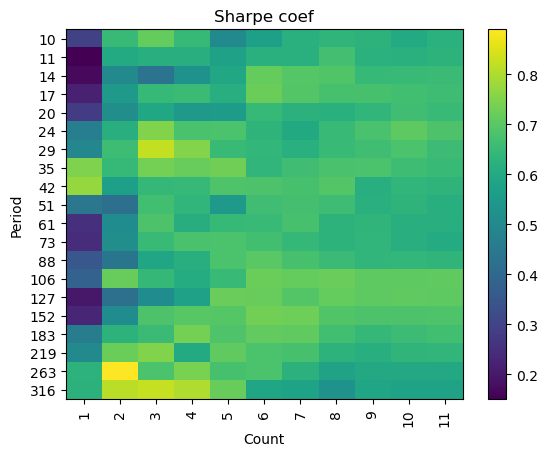

In [ ]:
stats_pivot = stats.pivot(index = 'period', columns = 'count', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(portfolio_counts)), portfolio_counts, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Count')
plt.ylabel('Period')
_ = plt.colorbar()

# plt.savefig(r'cross_mom_opt.png', dpi = 1200)
# plt.savefig(r'cross_mom_opt_lowq.png')


Best set of parameters:

In [ ]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Count = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  0.8901567142836343
Period =  263 Count =  2


We calculate equity on data that includes a test period:

Sharpe ratio = 0.57
Annual Return = 0.09
Annual Std = 0.17


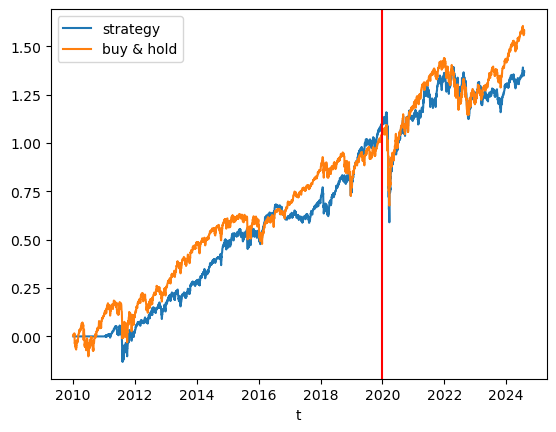

In [ ]:
_, eq = strategy_backtest(test, bh, [best_is_stats['period'].astype(int), best_is_stats['count'].astype(int)], True, in_sample_end)

# plt.savefig(r'cross_mom_bt.png', dpi = 1200)
# plt.savefig(r'cross_mom_bt_lowq.png')


Calculate statistics on test data:

Sharpe ratio = 0.26
Annual Return = 0.06
Annual Std = 0.23


,Sharpe ratio,Annual return,Volatility
_,0.261976,0.06077,0.231966


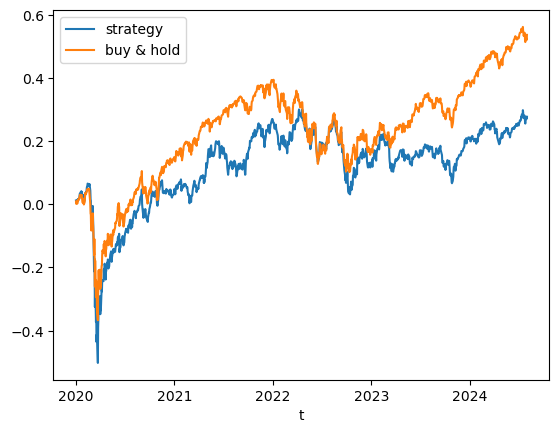

In [ ]:
statistics_calc(eq[in_sample_end:], bh[in_sample_end:], name = "_", plot = True)

Start date,2010-01-05
End date,2024-07-31
Total months,174
,Backtest
Annual return,8.368%
Cumulative returns,222.019%
Annual volatility,16.52%
Sharpe ratio,0.57
Calmar ratio,0.18
Stability,0.96
Max drawdown,-45.845%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.84,2020-02-14,2020-03-23,2021-05-05,319
1,24.52,2022-04-08,2022-10-14,NaT,NaN
2,17.78,2011-07-07,2011-08-10,2012-02-13,158
3,14.27,2018-01-26,2018-04-02,2018-07-06,116
4,12.18,2018-12-03,2018-12-24,2019-01-31,44


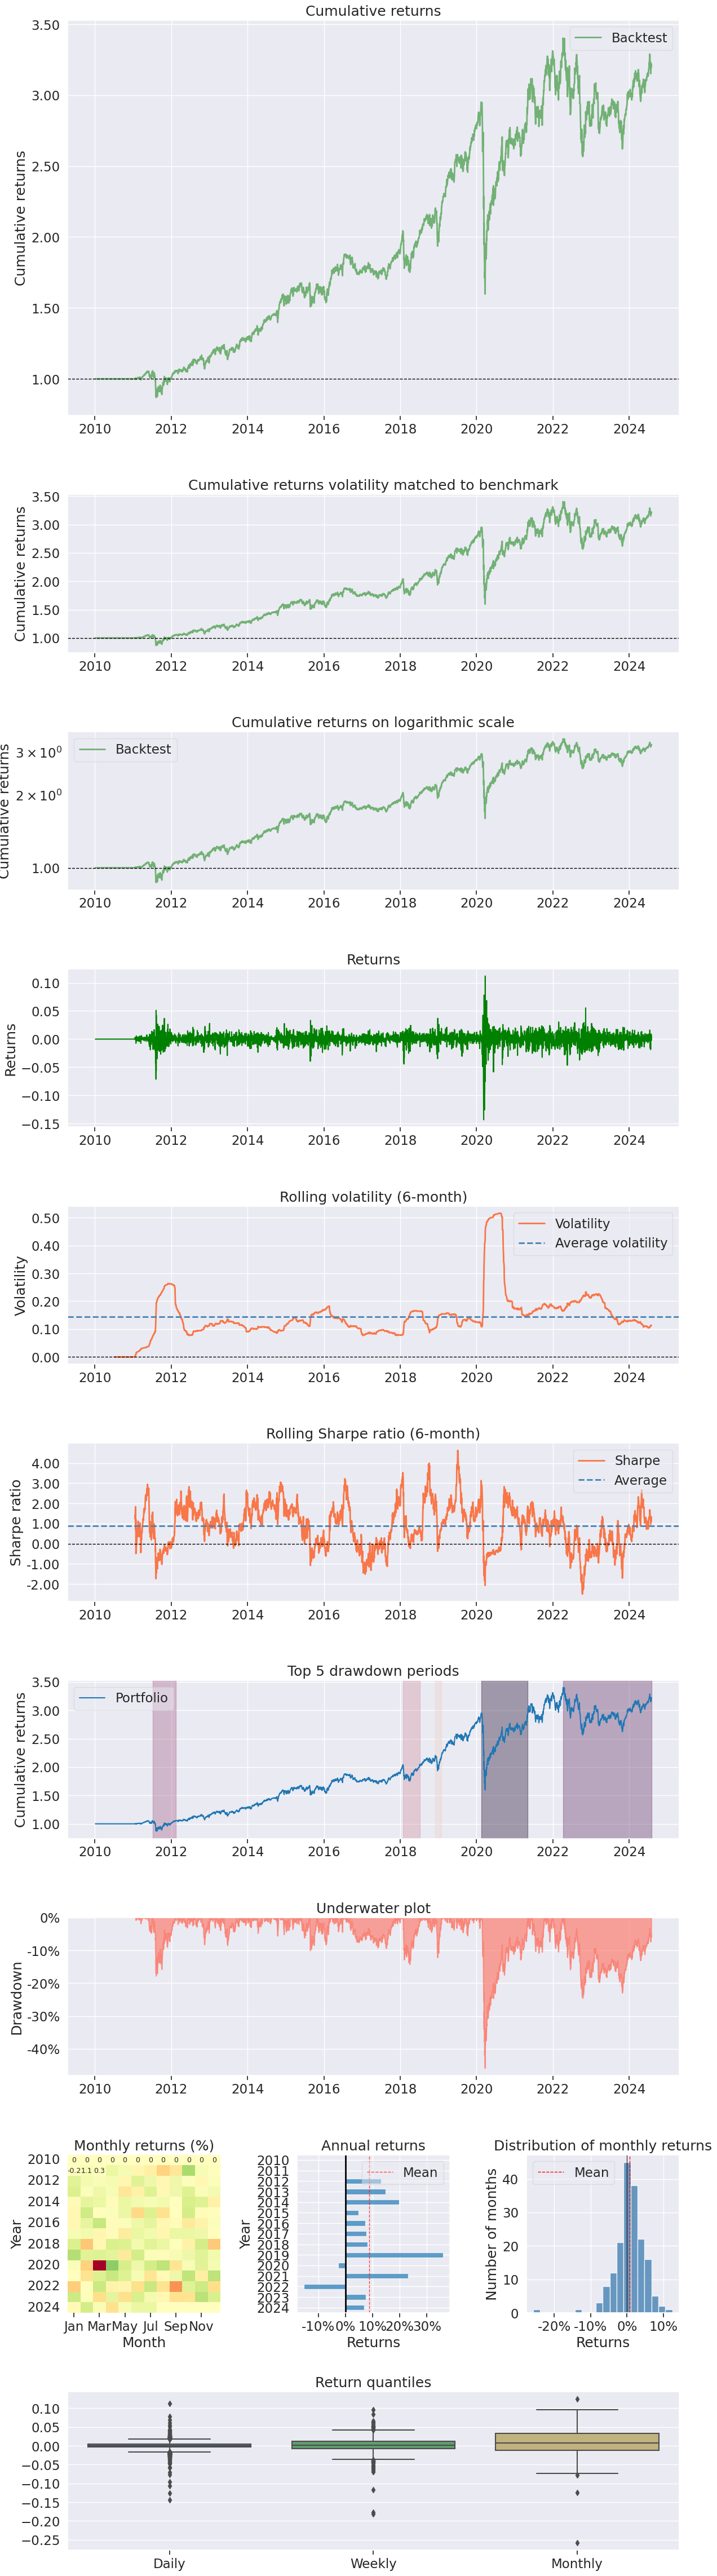

In [ ]:
# Disabling compatibility errors
import warnings
warnings.filterwarnings('ignore')

import pyfolio as pf

pd.Series.iteritems = pd.Series.items
f = pf.create_returns_tear_sheet(eq, return_fig = True)

$\alpha$ and $\beta$ calculation:

In [ ]:
risk_free_rate = 0.02

eq_bh = pd.DataFrame(eq).merge(pd.DataFrame(bh), how = 'outer', left_index = True, right_index = True).fillna(0)
eq_bh.columns = ['eq', 'bh']
reg = LinearRegression().fit( eq_bh['bh'].values.reshape(-1, 1)-risk_free_rate/days_in_year, eq_bh['eq'].values.reshape(-1, 1)-risk_free_rate/days_in_year)

In [ ]:
alpha = reg.intercept_[0]*days_in_year
beta = reg.coef_[0][0]

print('alpha = ', alpha)
print('beta = ', beta)

alpha =  0.0035330397141995944
beta =  0.7969605347886831


Market-neutral portfolio:

Sharpe ratio = 0.08
Annual Return = 0.01
Annual Std = 0.09


,Sharpe ratio,Annual return,Volatility
True,0.082827,0.007594,0.091683


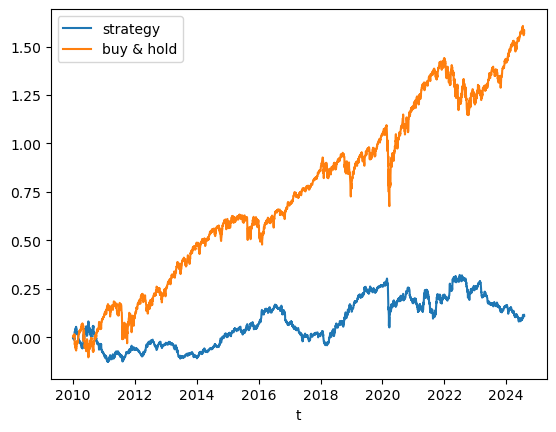

In [ ]:
statistics_calc(eq_bh['eq']-beta*eq_bh['bh'], eq_bh['bh'], True, in_sample_end)

Additional exercises and research topics:



1. Develop and test your own strategy using the cross-section momentum effect (for stocks, ETFs or futures).